In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# constants:
A = 0.84
kappa = 1.7e1
H = 12
L = 1.9e4
r = 0.24
# h0 = 0.0025
h0 = 0.00025
omega = 1.4e-4



def perform_numerical_computation(A, kappa, H, L, r, h0, omega, nx):

    dx = 1 / nx
    dt = 0.9 / np.sqrt(kappa) * dx
    nt = int(100 / dt)


    x_x = np.linspace(-dx, 1 + dx, nx + 2)

    u_xt_ = np.zeros((nx + 2, nt + 1))
    D_xt_ = np.zeros((nx + 2, nt + 1))
    l_t_ = np.zeros(nt + 1)

    D_xt_[0, 0] = 1 + A / H
    D_xt_[:, 0] = (H + A) / H - x_x # since x_x = h_x
    l_t_[0] = 1 # 1.95e4 / 1.9e4



    def update_l(l__t, u_x_t, dt):
        return l__t + u_x_t[-1] * dt

    def update_D(l__t1, l__t2, u_x_t, x_x, D_x_t, dt, dx, t):
        D_x_t2 = np.zeros(nx + 2)
        D_x_t2[0] = A / H * np.cos(t) + 1
        D_x_t2[-1] = 0 # redundant
        D_x_t2[1:-1] = (D_x_t[2:] + D_x_t[:-2]) / 2 + x_x[1:-1] * (l__t2 - l__t1) / l__t1 * (D_x_t[2:] - D_x_t[:-2]) / (2 * dx) - dt / (2 * dx * l__t1) * (D_x_t[2:] * u_x_t[2:] - D_x_t[:-2] * u_x_t[:-2])

        
        return D_x_t2


    def update_u(l__t1, l__t2, u_x_t, x_x, h_x, D_x_t, D_x_t2, dt, dx):
        Lambda = r / (D_x_t2 + h0)


        u_x_t2 = np.zeros(nx + 2)

        u_x_t2[0]    = (u_x_t[0]                     - dt / (2 * dx * l__t1) * (u_x_t[0] *                           (-3*u_x_t[0] + 4 * u_x_t[1] - u_x_t[2]) + kappa * (-3 * D_x_t[0] + 4 * D_x_t[1] - D_x_t[2] - 3 * h_x[0] + 4 * h_x[1] - h_x[2]))) / (1 + Lambda[0] * dt)

        u_x_t2[-1]   = (u_x_t[-1]                    - dt / (2 * dx * l__t1) * ((u_x_t[0] - (l__t2 - l__t1) / dt ) * (3*u_x_t[-1] - 4 * u_x_t[-2] + u_x_t[-3]) + kappa * (3 * D_x_t[-1] - 4 * D_x_t[-2] + D_x_t[-3] + 3 * h_x[-1] - 4 * h_x[-2] + h_x[-3]))) / (1 + Lambda[-1] * dt)

        u_x_t2[1:-1] = ((u_x_t[2:] + u_x_t[:-2]) / 2 + dt / (2 * l__t1 * dx) * ((x_x[1:-1] * (l__t2 - l__t1) / dt - u_x_t[1:-1]) * (u_x_t[2:] - u_x_t[:-2]) - kappa * (D_x_t[2:] - D_x_t[:-2] + h_x[2:] - h_x[:-2]))) / (1 + Lambda[1:-1] * dt)
        
        return u_x_t2


    for timestep in range(nt):
        l_t_[timestep + 1] = update_l(l_t_[timestep], u_xt_[:, timestep], dt)
        D_xt_[:, timestep + 1] = update_D(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, D_xt_[:, timestep], dt, dx, timestep * dt)
        u_xt_[:, timestep + 1] = update_u(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, x_x * l_t_[timestep], D_xt_[:, timestep], D_xt_[:, timestep + 1], dt, dx)

    t = np.linspace(0, dt * nt, nt + 1)
    return t, l_t_, D_xt_, u_xt_




100
500
1000
1500


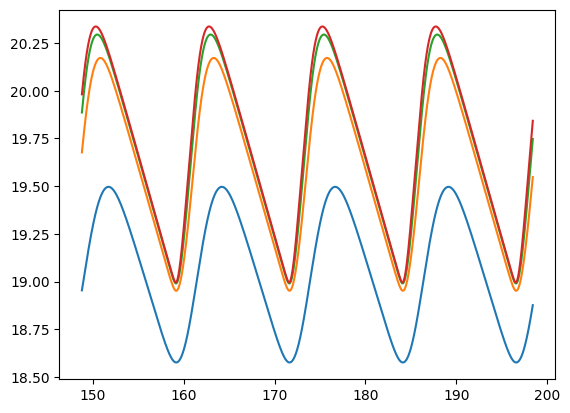

In [2]:
nx = 500
# for r in [0.24, 0.48, 0.96]:
# for nx in [100, 500, 1000, 2500]:
for nx in [100, 500, 1000, 1500]:
    print(nx)
    t, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, L, r, h0, omega, nx)

    plt.plot(t[len(t)*3//4:] / omega / 3600, l_t_[len(t)*3//4:] * L / 1000)

plt.rcParams["figure.figsize"] = (12,6)
plt.show()


